In [2]:
from sandbox.toolbox.models import ResNet112, ResNet56, ResNet20, ResNetBaby

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from rich import print as pprint
import os
import glob

from scipy.stats import kurtosis
import pywt
from scipy.stats import skew
from torchvision.transforms import GaussianBlur
import torch.fft as fft

device = 'cuda'
plt.rcParams['image.cmap'] = 'magma'

In [3]:
ds = torchvision.datasets.CIFAR100
mean, std = (0.5071, 0.4867, 0.4409), (0.267, 0.256, 0.276) 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

testset = ds(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False, num_workers=0)

testloader_data = next(iter(testloader))
sample_idx_iter = iter(range(10000))

MODELS = {
    'ResNet112': ResNet112,
    'ResNet56': ResNet56,
    'ResNet20': ResNet20,
    'ResNetBaby': ResNetBaby
}

current = {}

root_dir = "experiments-24-03"
pth_files = glob.glob(os.path.join(root_dir, "**/Cifar100_ResNet*.pth"), recursive=True)
for file_path in pth_files:
    split = file_path.split('\\')[1:]

    run_number, distillation_type = (split[2], 'None') if split[2].isdigit() else (split[3], split[2])
    model_name = split[1].split('_')[0] 

    if run_number == '1':
        model = MODELS[model_name](100).to(device)
        checkpoint = torch.load(file_path, weights_only=True)
        model.load_state_dict(checkpoint['weights'])
        current[f'{model_name}_{distillation_type}'] = model
        print(f'Loaded: {model_name}-{distillation_type}')


Files already downloaded and verified
Loaded: ResNet112-None
Loaded: ResNet20-None
Loaded: ResNet20-ft
Loaded: ResNet20-kd
Loaded: ResNet20-td
Loaded: ResNet56-None
Loaded: ResNet56-ft
Loaded: ResNet56-kd
Loaded: ResNet56-td
Loaded: ResNetBaby-None
Loaded: ResNetBaby-ft
Loaded: ResNetBaby-kd
Loaded: ResNetBaby-td


In [4]:
def get_batch(Model):
    Model.eval()
    inputs, targets = testloader_data 
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        outputs = Model(inputs)
    probs = torch.nn.functional.softmax(outputs[3], dim=1)
    confidence, predicted = torch.max(probs.data, 1)

    return [{
        'feature_map': [outputs[idx][i] for idx in range(3)],
        'correct': predicted.eq(targets.data).cpu().float()[i].item() == 1.0,
        'predicted_class': np.array(testloader.dataset.classes)[predicted.data.cpu()][i],
        'correct_class': np.array(testloader.dataset.classes)[targets.data.cpu()][i],
        'confidence': confidence[i].item()
    } for i in range(10000)]

batch = {}
for key in current:
    batch[key] = get_batch(current[key]) 

In [5]:
def print_sample_data(index, batch):
    batch_sample = batch[index]
    print(batch_sample['correct'], '| Predicetd', batch_sample['predicted_class'], '| Actual', batch_sample['correct_class'], ' | Confidence', f'{batch_sample['confidence'] * 100:.2f}%')

def show_sample(index):
    images, labels = testloader_data
    img = images[index]
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def process_feature_map(feature_map):
    fmap = feature_map.cpu()  # Shape: [1, C, H, W]
    fmap_avg = torch.mean(fmap, dim=1, keepdim=True)  # Shape: [1, 1, H, W]
    batch_size, _, h, w = fmap_avg.shape
    fmap_flat = fmap_avg.view(batch_size, -1)  # Shape: [1, H*W]
    tau = 0.5
    fmap_scaled = fmap_flat / tau
    fmap_softmax = torch.softmax(fmap_scaled, dim=1)  # Shape: [1, H*W]
    fmap_softmax = fmap_softmax * (h * w)  # Scale by H*W
    fmap_processed = fmap_softmax.view(1, 1, h, w)  # Shape: [1, 1, H, W]
    return fmap_processed[0, 0].unsqueeze(0).unsqueeze(0).to(device)

def visualize_processed_feature_map(index, batch):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        feature_map = batch[index]['feature_map'][i].unsqueeze(0)
        processed_fmap = process_feature_map(feature_map)[0,0].cpu()
        plt.subplot(1, 3, i+1)
        plt.imshow(processed_fmap, vmin=0)
        plt.axis('off')
        plt.title(f'Feature Map #{i+1}')
    plt.show()

def visualize_channels(index, batch):
    fig, axs = plt.subplots(4, 12, figsize=(15, 5))  
    for k in range(3): 
        feature_map = batch[index]['feature_map'][k].unsqueeze(0)
        for i in range(4):
            for j in range(4):
                axs[i, j + k*4].matshow(feature_map[0, (i * 4) + j].cpu(), vmin=0)
                axs[i, j + k*4].axis('off')
        axs[0, k*4].set_title(f'Feature Map #{k+1}')
    plt.tight_layout()
    plt.show()

def show_random_feature_map():
    feature_map = torch.randn(1, 64, 8, 8).to(device)
    processed_fmap = process_feature_map(feature_map)[0,0].cpu()

    plt.figure(figsize=(5, 5))
    plt.imshow(processed_fmap, vmin=0)
    plt.axis('off')
    plt.show()

    fig, axs = plt.subplots(8, 8, figsize=(5, 5)) 
    for i in range(8):
        for j in range(8):
            axs[i, j].matshow(feature_map[0, (i * 8) + j].cpu(),vmin=0) 
            axs[i, j].axis('off')

In [ ]:
# show_random_feature_map()
# sample_idx = next(sample_idx_iter)
sample_idx = 3022 # random.randint(0,9999)
show_sample(sample_idx)
for key in batch:
    print(key)
    print_sample_data(sample_idx, batch[key])
    visualize_processed_feature_map(sample_idx, batch[key])
    visualize_channels(sample_idx, batch[key])

In [7]:
def compute_wavelet_energy(feature_map, wavelet='db1', level=2):
    energies = []
    for c in range(feature_map.shape[1]):  # Iterate over channels
        fm_np = feature_map[0, c].detach().cpu().numpy()
        coeffs = pywt.wavedec2(fm_np, wavelet, level=level)
        high_freq_energy = 0
        for detail in coeffs[1:]:  # Each detail is a tuple of arrays
            for subband in detail:
                high_freq_energy += np.sum(subband**2)
        energies.append(high_freq_energy)
    
    energies = torch.tensor(energies)
    avg = energies.mean().item()
    return avg

def compute_skewness(feature_map):
    flat_fm = feature_map.flatten().detach().cpu().numpy()
    skewness = skew(flat_fm)
    return skewness

def compute_lowpass_residuals(feature_map, kernel_size=3, sigma=1.0):
    blur = GaussianBlur(kernel_size, sigma)
    denoised_fm = blur(feature_map)
    residuals = torch.norm(feature_map - denoised_fm, p=2)
    return residuals.item()

def compute_frequency_entropy(feature_map):
    channels = feature_map.shape[1]
    entropies = []
    for c in range(channels):
        fm = feature_map[0, c]  
        fm_fft = fft.fft2(fm)
        power_spectrum = torch.abs(fm_fft)**2
        probs = power_spectrum / (power_spectrum.sum() + 1e-10)
        entropy = -torch.sum(probs * torch.log(probs + 1e-10))
        entropies.append(entropy)
    
    entropies = torch.tensor(entropies)
    avg = entropies.mean()
    return avg.item()

def compute_iqr(feature_map):
    flat_fm = feature_map.flatten()
    q75, q25 = torch.quantile(flat_fm, torch.tensor([0.75, 0.25],device=device))
    iqr = q75 - q25
    return iqr.item()

def compute_high_freq_power(feature_map):
    channels = feature_map.shape[1]
    high_freq_powers = []
    for c in range(channels):
        fm = feature_map[0, c] 
        fm_fft = fft.fft2(fm)
        power_spectrum = torch.abs(fm_fft)**2
        high_freq_power = power_spectrum[int(fm.shape[0]/2):, int(fm.shape[1]/2):].sum()
        high_freq_powers.append(high_freq_power)
    
    high_freq_powers = torch.tensor(high_freq_powers)
    avg = high_freq_powers.mean().item()
    return avg

def compute_cv(feature_map):
    mean = torch.mean(feature_map)
    std = torch.std(feature_map)
    cv = mean / (std.abs() + 1e-10)
    return cv.item()

def compute_kurtosis(feature_map):
    flat_fm = feature_map.flatten().detach().cpu().numpy()
    return kurtosis(flat_fm)

def compute_entropy(feature_map): 
    feature_map = feature_map - feature_map.min()  
    sum_fm = feature_map.sum()
    if sum_fm == 0:  # Avoid division by zero
        return torch.tensor(0.0, device=feature_map.device)
    probs = feature_map / sum_fm
    entropy = -torch.sum(probs * torch.log(probs + 1e-10))
    return entropy.item()

def compute_average(feature_map):
    return feature_map.mean().item()

def compute_std(feature_map):
    return feature_map.std().item()

metrics = { 
    "Average": compute_average,
    "STD": compute_std,
    "Kurtosis": compute_kurtosis,
    "Wavelet High-Frequency Energy": compute_wavelet_energy,
    "Low-Pass Filter Residuals": compute_lowpass_residuals,
    "Frequency Entropy": compute_frequency_entropy,
    "IQR": compute_iqr,
    "High-Frequency Power": compute_high_freq_power,
    "Coefficient of Variation": compute_cv,
    "Skewness": compute_skewness,
    "Total Entropy": compute_entropy,
}
    

In [8]:
def analyze_feature_map_multiple_samples(batch_model, title, fidx, process=False, batch_size=1000):
    results = {"Feature Map": title}
    for name, func in metrics.items():
        number = 0
        for i in range(batch_size):
            feature_map = batch_model[i]['feature_map'][fidx].unsqueeze(0)
            number += func(process_feature_map(feature_map) if process else feature_map)
        number /= batch_size
        results.update({name: round(number,4)})
    return results

def analyze_feature_map_to_table(feature_map_list, titles):
    rows = []
    for feature_map, title in zip(feature_map_list, titles):
        results = {"Feature Map": title}  # Add title as a column
        results.update({name: round(func(feature_map), 4) for name, func in metrics.items()})
        rows.append(results)
    return rows
    # try:
    #     df.to_excel("feature_map_metrics.xlsx", index=False)  # index=False keeps it as a column
    #     print("Saved to 'feature_map_metrics.xlsx'")
    # except ModuleNotFoundError:
    #     print("Error: Install 'openpyxl' to save to Excel (pip install openpyxl)")

In [ ]:
temp = {"Feature Map": ""}
for name, func in metrics.items():
    temp.update({name: 0})

for i in range(3):
    rows = []
    for key, value in batch.items():
        rows.append(analyze_feature_map_multiple_samples(batch[key], key, i))

    rows.append(temp)
    rows.append(temp)

    for key, value in batch.items(): # Process feature map before calculating stats
        rows.append(analyze_feature_map_multiple_samples(batch[key], key, i, process=True))

    rows.append(temp)
    rows.append(temp)


    random_fmap = torch.randn(1, 64, 8, 8).to(device)
    squashed_random_fmap = process_feature_map(random_fmap)
    rows += analyze_feature_map_to_table([random_fmap, squashed_random_fmap], ['Random', 'Random Squashed'])


    df = pd.DataFrame(rows)
    df.to_excel(f'metrics_fmaps_{i}.xlsx')
    print(df.to_string(index=False))

In [ ]:
import pandas as pd

# Load each table from xlsx files (replace with your file paths)
data1 = pd.read_excel("metrics_fmaps_0.xlsx")  # First document
data2 = pd.read_excel("metrics_fmaps_1.xlsx")  # Second document
data3 = pd.read_excel("metrics_fmaps_2.xlsx")  # Third document

# Function to compute correlations with Total Entropy only
def compute_entropy_correlations(df, table_name):
    # Drop rows with all zeros and unnecessary columns
    df = df.loc[df["Average"] != 0].drop(columns=["Unnamed: 0", "Feature Map"])
    
    # Compute correlation matrix
    corr_matrix = df.corr()
    
    # Extract only the Total Entropy row from the correlation matrix
    entropy_correlations = corr_matrix.loc["Total Entropy"]
    
    # Print results
    print(f"\nCorrelations with Total Entropy for {table_name}:")
    for metric, corr_value in entropy_correlations.items():
        if metric != "Total Entropy":  # Skip self-correlation
            print(f"{metric}: {corr_value:.4f}")
            # print(f"{metric}")

# Run for each table
for fm_idx, data in enumerate([data1, data2, data3]):
    subtable1 = data.iloc[0:13].loc[data["Average"] != 0]
    subtable2 = data.iloc[15:28].loc[data["Average"] != 0]
    fm_names = ["Normal", "Attention Map"]
    for table_idx, table in enumerate([subtable1, subtable2]):
        ft_subtable = table[table["Feature Map"].isin(["ResNet56_ft", "ResNet20_ft", "ResNetBaby_ft"])]
        kd_subtable = table[table["Feature Map"].isin(["ResNet56_kd", "ResNet20_kd", "ResNetBaby_kd"])]
        td_subtable = table[table["Feature Map"].isin(["ResNet56_td", "ResNet20_td", "ResNetBaby_td"])]
        none_subtable = table[table["Feature Map"].isin(["ResNet112_None", "ResNet56_None", "ResNet20_None", "ResNetBaby_None"])]
        table_method_names = ["ft_subtable", "kd_subtable", "td_subtable", "none_subtable"]
        for method_idx, table_method in enumerate([ft_subtable, kd_subtable, td_subtable, none_subtable]):
            compute_entropy_correlations(table_method, f"Table {fm_idx+1}, {fm_names[table_idx]}, {table_method_names[method_idx]}")
    print("\n", "============================================"*2, "\n")




#     compute_entropy_correlations(subtable1, f"Table {i}")
#     compute_entropy_correlations(subtable2, f"Table {i}/Attention Map")


# ft_subtable = subtable1[subtable1["Feature Map"].isin(["ResNet56_ft", "ResNet20_ft", "ResNetBaby_ft"])]
# kd_subtable = subtable1[subtable1["Feature Map"].isin(["ResNet56_kd", "ResNet20_kd", "ResNetBaby_kd"])]
# td_subtable = subtable1[subtable1["Feature Map"].isin(["ResNet56_td", "ResNet20_td", "ResNetBaby_td"])]
# none_subtable = subtable1[subtable1["Feature Map"].isin(["ResNet112_None", "ResNet56_None", "ResNet20_None", "ResNetBaby_None"])]


# QUESTION:
1. What does the paraphraser, translater and TD do with the feature maps?


Files already downloaded and verified
First channel of final feature map of the 0th sample (ray) out of the dataset


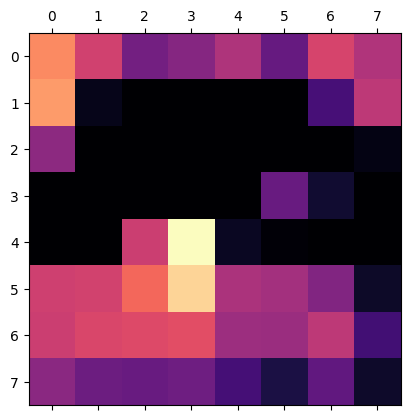

First channel of final feature map of the 1th sample (skyscraper) out of the dataset


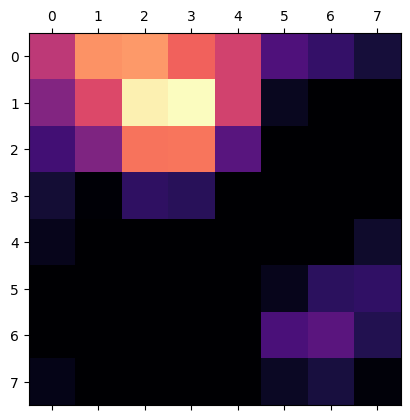

First channel of final feature map of the 2th sample (beetle) out of the dataset


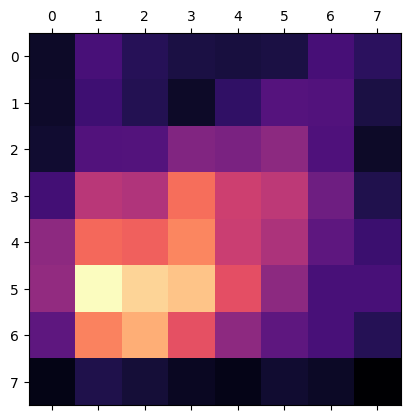

First channel of final feature map of the 3th sample (chimpanzee) out of the dataset


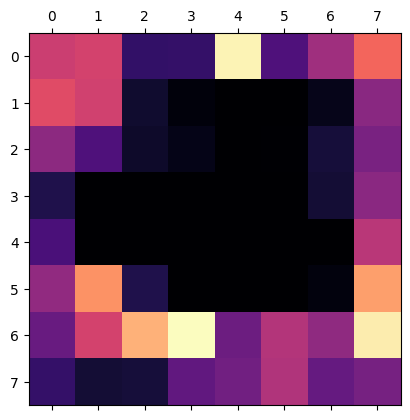

First channel of final feature map of the 4th sample (television) out of the dataset


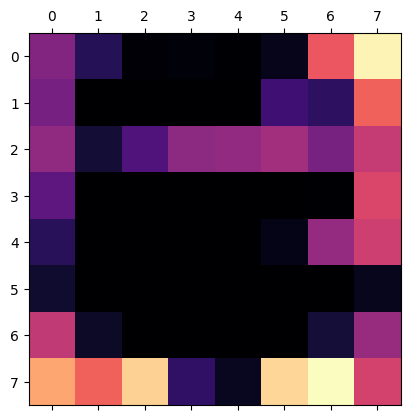

First channel of final feature map of the 5th sample (turtle) out of the dataset


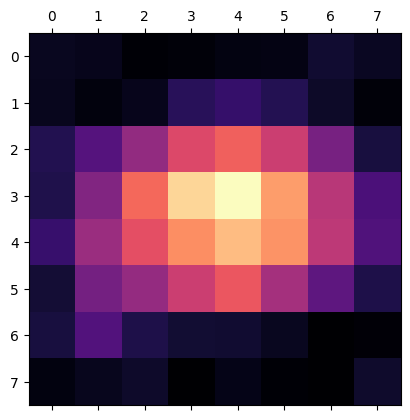

First channel of final feature map of the 6th sample (otter) out of the dataset


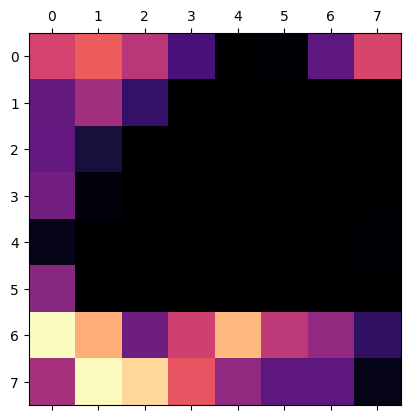

First channel of final feature map of the 7th sample (kangaroo) out of the dataset


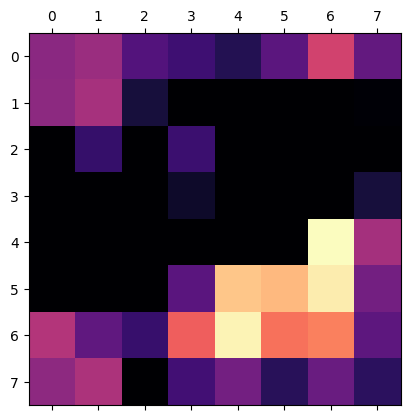

First channel of final feature map of the 8th sample (streetcar) out of the dataset


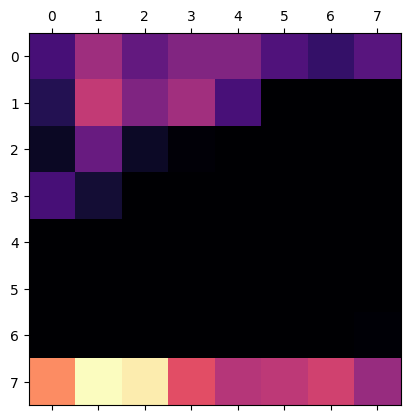

First channel of final feature map of the 9th sample (keyboard) out of the dataset


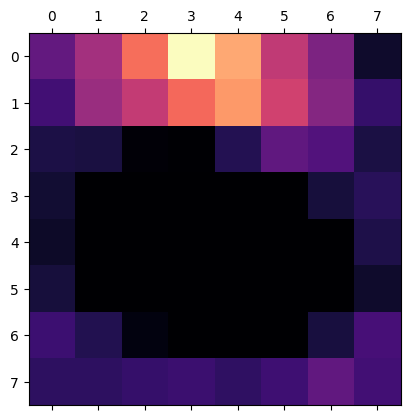

In [51]:
# print(batch['ResNet56_ft'][0].keys())
batch_size = 10 #len(testset)
testset = ds(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader_data = next(iter(testloader))


inputs, targets = testloader_data 
inputs, targets = inputs.to(device), targets.to(device)
rn56 = current['ResNet56_ft']
rn56.eval()
with torch.no_grad():
    outputs = rn56(inputs)
probs = torch.nn.functional.softmax(outputs[3], dim=1)
confidence, predicted = torch.max(probs.data, 1)

thing = [{
    'feature_map':outputs[2][i],
    'correct': predicted.eq(targets.data).cpu().float()[i].item() == 1.0,
    'predicted_class': np.array(testloader.dataset.classes)[predicted.data.cpu()][i],
    'correct_class': np.array(testloader.dataset.classes)[targets.data.cpu()][i],
    'confidence': confidence[i].item()
} for i in range(10)]

for i in range(10):
    feature_map = thing[i]['feature_map'][0].cpu() 
    predicted = thing[i]['predicted_class']
    plt.matshow(feature_map)
    print(f'First channel of final feature map of the {i}th sample ({predicted}) out of the dataset')
    plt.show()


In [ ]:


current = {}

root_dir = "experiments-24-03"
pth_files = glob.glob(os.path.join(root_dir, "**/Cifar100_ResNet*.pth"), recursive=True)
for file_path in pth_files:
    split = file_path.split('\\')[1:]

    run_number, distillation_type = (split[2], 'None') if split[2].isdigit() else (split[3], split[2])
    model_name = split[1].split('_')[0] 

    if run_number == '1':
        model = MODELS[model_name](100).to(device)
        checkpoint = torch.load(file_path, weights_only=True)
        model.load_state_dict(checkpoint['weights'])
        current[f'{model_name}_{distillation_type}'] = model
        print(f'Loaded: {model_name}-{distillation_type}')


For a single model, compare the noise stats for:
Confident wrong vs confident right vs uncertain wrong vs uncertain correct

for multiple variants of the smae model, compare:
Does it get the same things right and wrong